# Compute ToE in boxes for signal and noise analyzed on pressure surfaces and mapped to gamma, for IPSL r2i1p1

In [1]:
import sys
sys.path.append("/home/ysilvy/Density_bining/Yona_analysis/programs/")
import numpy as np
from netCDF4 import Dataset as open_ncfile
from maps_matplot_lib import defVarmme, averageDom
from libToE import findToE, ToEdomainrcp85vshistNat
from functions_z_analysis import maptogamma
import glob
sys.path.append("/home/ysilvy/Density_bining/")
from binDensity import rhonGrid
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import datetime

In [9]:
# varname = defVarmme('salinity'); v = 'S'
varname = defVarmme('temp'); v = 'T'
var = varname['var_zonal_w/bowl']
if v=='S':
    varName = 'salinity'
elif v=='T':
    varName = 'temperature'

In [10]:
indir = '/data/ysilvy/CMIP5_annual/'
domains = ['Southern ST', 'SO', 'Northern ST', 'North Atlantic', 'North Pacific']

iniyear = 1860
finalyear = 2100
deltay = 10.

legVar = varname['legVar']

model = {'name':'IPSL-CM5A-LR'  ,'props':[6,3,11,156], 'picontrol':[1000],'correctFile':[0,0,0],
          'file_end_hist':'v20111119', 'file_end_histNat':'v20120430',
          'hist-rcp85':['r2i1p1','r3i1p1','r4i1p1']}
tstart = model['props'][2]
tend = model['props'][3]

In [5]:
# ----- Map to gamma, average signal and noise and compute ToE ------
print('Computing ToE for ',model['name'])

# Read hist+rcp85 file
filehrcp = indir + 'so_thetao_gamma_Oan_IPSL-CM5A-LR_historical-rcp85_r2i1p1_185001-210012.nc'
fhrcp = open_ncfile(filehrcp,'r')
varhrcp = fhrcp.variables[varName][tstart-1:tend+95,:,:,:]
varhrcp.shape
# Read histNat file
filehn = indir + 'so_thetao_gamma_Oan_IPSL-CM5A-LR_historicalNat_r2i1p1_185001-201012.nc'
fhn = open_ncfile(filehn,'r')
# Read var histNat
varhn = fhn.variables[varName][tstart:tend,:,:,:]
# varhn.shape

('Computing ToE for ', 'IPSL-CM5A-LR')


In [7]:
varName, var

('temperature', 'isonthetao')

In [8]:
# -- Map hist+rcp and histNat to gamma at each time step
# Density grid
targetrho, s_sax, del_s, N_s = rhonGrid(19, 26, 28.501, 0.2, 0.1)

# Define Gamma/depth relationship for mapping
gammaz = np.ma.average(fhrcp.variables['density'][tstart-1:tend+95,:,:,:],axis=0)

# Map to gamma
varhrcp_gamma = np.ma.masked_all((varhrcp.shape[0],varhrcp.shape[1],len(targetrho),varhrcp.shape[3]))
varhn_gamma = np.ma.masked_all((varhn.shape[0],varhn.shape[1],len(targetrho),varhn.shape[3]))
for t in range(varhrcp.shape[0]):
    varhrcp_gamma[t,:,:,:] = maptogamma(varhrcp[t,:,:,:],gammaz,targetrho)
    if t<varhn.shape[0]:
        varhn_gamma[t,:,:,:] = maptogamma(varhn[t,:,:,:],gammaz,targetrho)


In [9]:
timN = 240
basinN = 4
lat = fhrcp.variables['latitude'][:]
density = targetrho

In [10]:
varhn_gamma.shape

(145, 4, 61, 180)

In [11]:
# -- Now work in gamma space
# Compute mean histNat
varmeanhn = np.ma.average(varhn_gamma,axis=0)

# Initialize varnoise for each basin, containing averaged noise for each domain
varnoise_a = np.ma.masked_all(len(domains))
varnoise_p = np.ma.masked_all(len(domains))
varnoise_i = np.ma.masked_all(len(domains))
# Initialize varsignal for each basin, containing averaged signal for each domain
varsignal_a = np.ma.masked_all((timN,len(domains)))
varsignal_p = np.ma.masked_all((timN,len(domains)))
varsignal_i = np.ma.masked_all((timN,len(domains)))
# Initialize toe 1 and 2 for each basin (run, domain)
toe1_a = np.ma.masked_all(len(domains))
toe1_p = np.ma.masked_all(len(domains))
toe1_i = np.ma.masked_all(len(domains))
toe2_a = np.ma.masked_all(len(domains))
toe2_p = np.ma.masked_all(len(domains))
toe2_i = np.ma.masked_all(len(domains))
# Initialize output variable
varToE1 = np.ma.masked_all((basinN,len(domains))) # (basin,domain) 1std
varToE2 = np.ma.masked_all((basinN,len(domains))) # (basin,domain) 2std

# Loop over 5 domains
for j, domain_name in enumerate(domains):
    print('- ', j, domains[j])

    # Select domain to average
    domain = ToEdomainrcp85vshistNat(model['name'], domain_name)[0]
    domain_char = ToEdomainrcp85vshistNat(model['name'], domain_name)[1]

    # Average histNat and compute std
    if domain['Atlantic'] != None:
        varnoise_a[j] = np.ma.std(averageDom(varhn_gamma[:,1,:,:], 3, domain['Atlantic'], lat, density),axis=0)
    if domain['Pacific'] != None:
        varnoise_p[j] = np.ma.std(averageDom(varhn_gamma[:,2,:,:], 3, domain['Pacific'], lat, density),axis=0)
    if domain['Indian'] != None:
        varnoise_i[j] = np.ma.std(averageDom(varhn_gamma[:,3,:,:], 3, domain['Indian'], lat, density),axis=0)

    # Average signal hist+RCP8.5 - histNat
    if domain['Atlantic'] != None:
        varsignal_a[0:145,j] = averageDom(varhrcp_gamma[0:145,1,:,:]-varhn_gamma[:,1,:,:], 3, domain['Atlantic'], lat, density)
        varsignal_a[145:,j] = averageDom(varhrcp_gamma[145:,1,:,:]-varmeanhn[1,:,:], 3, domain['Atlantic'], lat, density)
        
    if domain['Pacific'] !=None:
        varsignal_p[0:145,j] = averageDom(varhrcp_gamma[0:145,2,:,:]-varhn_gamma[:,2,:,:], 3, domain['Pacific'], lat, density)
        varsignal_p[145:,j] = averageDom(varhrcp_gamma[145:,2,:,:]-varmeanhn[2,:,:], 3, domain['Pacific'], lat, density)
        
    if domain['Indian'] != None:
        varsignal_i[0:145,j] = averageDom(varhrcp_gamma[0:145,3,:,:]-varhn_gamma[:,3,:,:], 3, domain['Indian'], lat, density)
        varsignal_i[145:,j] = averageDom(varhrcp_gamma[145:,3,:,:]-varmeanhn[3,:,:], 3, domain['Indian'], lat, density)
        
    
    # Compute ToE of averaged domain
    if domain['Atlantic'] != None and np.ma.is_masked(varnoise_a[j]) == False:
        toe2_a[j] = findToE(varsignal_a[:,j], varnoise_a[j], 2) + iniyear
        toe1_a[j] = findToE(varsignal_a[:,j], varnoise_a[j], 1) + iniyear
    if domain['Pacific'] != None and np.ma.is_masked(varnoise_p[j]) == False:
        toe2_p[j] = findToE(varsignal_p[:,j], varnoise_p[j], 2) + iniyear
        toe1_p[j] = findToE(varsignal_p[:,j], varnoise_p[j], 1) + iniyear
    if domain['Indian'] != None and np.ma.is_masked(varnoise_i[j]) == False:
        toe2_i[j] = findToE(varsignal_i[:,j], varnoise_i[j], 2) + iniyear
        toe1_i[j] = findToE(varsignal_i[:,j], varnoise_i[j], 1) + iniyear

varToE1[1,:] = toe1_a
varToE1[2,:] = toe1_p
varToE1[3,:] = toe1_i
varToE2[1,:] = toe2_a
varToE2[2,:] = toe2_p
varToE2[3,:] = toe2_i

('- ', 0, 'Southern ST')
('- ', 1, 'SO')
('- ', 2, 'Northern ST')
('- ', 3, 'North Atlantic')
('- ', 4, 'North Pacific')


In [39]:
# -- Now read regional ToE analyzed in density
fileToE = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_rcp85_histNat_average_signal/average_histNat/cmip5.IPSL-CM5A-LR.toe_rcp_histNat_average_histNat.nc'    
fToE = open_ncfile(fileToE,'r')

varToE2_gamma = fToE.variables[var+'ToE2'][2,:,:] # 2 = 3rd position corresponds to r2i1p1

In [43]:
varToE2_gamma, varToE2, varToE2.shape

(masked_array(
   data=[[--, --, --, --, --],
         [2023.0, 2037.0, --, 2008.0, --],
         [1984.0, 2060.0, 1988.0, --, 2012.0],
         [2006.0, 2045.0, 2009.0, --, --]],
   mask=[[ True,  True,  True,  True,  True],
         [False, False,  True, False,  True],
         [False, False, False,  True, False],
         [False, False, False,  True,  True]],
   fill_value=9.96921e+36,
   dtype=float32), masked_array(
   data=[[--, --, --, --, --],
         [2032.0, 2095.0, --, 2100.0, --],
         [2040.0, 2100.0, 1989.0, --, 2041.0],
         [2016.0, 2030.0, 2034.0, --, --]],
   mask=[[ True,  True,  True,  True,  True],
         [False, False,  True, False,  True],
         [False, False, False,  True, False],
         [False, False, False,  True,  True]],
   fill_value=1e+20), (4, 5))

In [46]:
ToEz = np.array([varToE2[1,0], varToE2[2,0], varToE2[3,0], varToE2[2,2], varToE2[3,2],
          varToE2[1,1], varToE2[2,1], varToE2[3,1], varToE2[1,3], varToE2[2,4]])

ToEgamma = np.array([varToE2_gamma[1,0], varToE2_gamma[2,0], varToE2_gamma[3,0], varToE2_gamma[2,2], varToE2_gamma[3,2],
          varToE2_gamma[1,1], varToE2_gamma[2,1], varToE2_gamma[3,1], varToE2_gamma[1,3], varToE2_gamma[2,4]])

domain_names = ['Southern ST, Atlantic','Southern ST, Pacific', 'Southern ST, Indian',
              'Northern ST, Pacific', 'Northern ST, Indian',
              'Southern Ocean, Atlantic','Southern Ocean, Pacific', 'Southern Ocean, Indian',
              'North Atlantic',
              'North Pacific']

domain_colors = ['firebrick','darkorange','gold','yellowgreen','forestgreen',
                 'turquoise','deepskyblue','royalblue','mediumpurple','darkmagenta']



In [48]:
ToEz, ToEgamma

(array([2032., 2040., 2016., 1989., 2034., 2095., 2100., 2030., 2100.,
        2041.]),
 array([2023., 1984., 2006., 1988., 2009., 2037., 2060., 2045., 2008.,
        2012.], dtype=float32))

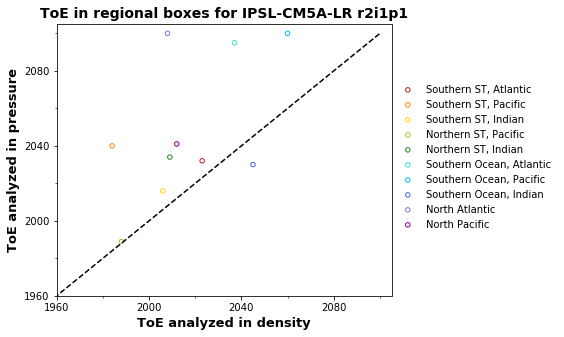

In [81]:
fig = plt.figure(figsize=(6,5))

l=['']*len(domain_names)

for idomain in range(len(domain_names)):
    col = domain_colors[idomain]
    l[idomain] = plt.scatter(ToEgamma[idomain],ToEz[idomain],color=col,s=20,facecolors='none', label=domain_names[idomain])
ax = plt.gca()
ax.set_title('ToE in regional boxes for '+model['name'] + ' r2i1p1 \n method 1: average signal/noise then compute ToE',fontsize=14,fontweight='bold')

# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)
    
ax.plot([1860,2000,2100],[1860,2000,2100], color='black', linestyle='--',zorder=1)

ax.set_ylim([1960,2105])
ax.set_xlim([1960,2105])
xmajorLocator = MultipleLocator(40)
xminorLocator = AutoMinorLocator(2)
ax.yaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_minor_locator(xminorLocator)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)

ax.set_xlabel('ToE analyzed in density', fontweight='bold',fontsize=13)
ax.set_ylabel('ToE analyzed in pressure', fontweight='bold',fontsize=13)

# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = fig.legend(l,domain_names,loc='center left',scatterpoints=1,frameon=False, bbox_to_anchor=(0.9, 0.5))

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Text at the bottom of the figure
#plt.figtext(.8,.01,'Computed by : compute_toe_z_inboxes.ipynb, '+date, fontsize=8, ha='center')

plotName = 'scatterplot_ToEzvsToEgamma_boxes'


plt.savefig('/home/ysilvy/figures/models/ToE_z_analysis/'+plotName+'.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')


# Now compare ToE in boxes by simply averaging ToE (not signal and noise first) 

In [11]:
indirz = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal_z/toe_rcp85_histNat/'
indirr = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_rcp85_histNat/'
# -- Read ToE in z mapped to gamma
legVar = varname['legVar']
filez = 'cmip5.IPSL-CM5A-LR.r2i1p1.'+legVar+'_toe_zonal_rcp_histNat.nc'
fz = open_ncfile(indirz+filez,'r')
toez = fz.variables[varName+'ToE2_gamma'][:] + 1860

# -- Read ToE in gamma
if v == 'S':
    filerho = 'cmip5.IPSL-CM5A-LR.toe_zonal_rcp_histNat.nc'
else:
    filerho = 'cmip5.IPSL-CM5A-LR.Temperature_toe_zonal_rcp_histNat.nc'
frho = open_ncfile(indirr+filerho,'r')
toerho = frho.variables[var+'ToE2'][2,:,:,:] + 1860 # index 2 (3rd position) corresponds to run r2i1p1 (ls -U order)
var_change = frho.variables[var+'_change'][2,:,:,:]
toerho.fill_value = 1.e20

if v=='S':
    idx = np.argwhere(var_change.mask==True)
    toerho[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked

In [12]:
lat = fz.variables['latitude'][:]
density = fz.variables['density'][:]

In [13]:
filerho

'cmip5.IPSL-CM5A-LR.Temperature_toe_zonal_rcp_histNat.nc'

In [14]:
# -- Average ToE in boxes
basinN=4
# Initialize ToE
ToEz = np.ma.masked_all((basinN,len(domains)))
ToErho = np.ma.masked_all((basinN,len(domains)))

# Loop over 5 domains
for j, domain_name in enumerate(domains):
    print('- ', j, domains[j])

    # Select domain to average
    domain = ToEdomainrcp85vshistNat(model['name'], domain_name)[0]

    # Average ToE
    if domain['Atlantic'] != None:
        ToEz[1,j] = np.int(averageDom(toez[1,:,:], 2, domain['Atlantic'], lat, density))
        ToErho[1,j] = np.int(averageDom(toerho[1,:,:], 2, domain['Atlantic'], lat, density))
    if domain['Pacific'] != None:
        ToEz[2,j] = np.int(averageDom(toez[2,:,:], 2, domain['Pacific'], lat, density))
        ToErho[2,j] = np.int(averageDom(toerho[2,:,:], 2, domain['Pacific'], lat, density))
    if domain['Indian'] != None:
        ToEz[3,j] = np.int(averageDom(toez[3,:,:], 2, domain['Indian'], lat, density))
        ToErho[3,j] = np.int(averageDom(toerho[3,:,:], 2, domain['Indian'], lat, density))


('- ', 0, 'Southern ST')
('- ', 1, 'SO')
('- ', 2, 'Northern ST')
('- ', 3, 'North Atlantic')
('- ', 4, 'North Pacific')


In [15]:
dataToEz = np.array([ToEz[1,0], ToEz[2,0], ToEz[3,0], ToEz[2,2], ToEz[3,2],
          ToEz[1,1], ToEz[2,1], ToEz[3,1], ToEz[1,3], ToEz[2,4]])

dataToErho = np.array([ToErho[1,0], ToErho[2,0], ToErho[3,0], ToErho[2,2], ToErho[3,2],
          ToErho[1,1], ToErho[2,1], ToErho[3,1], ToErho[1,3], ToErho[2,4]])

domain_names = ['Southern ST, Atlantic','Southern ST, Pacific', 'Southern ST, Indian',
              'Northern ST, Pacific', 'Northern ST, Indian',
              'Southern Ocean, Atlantic','Southern Ocean, Pacific', 'Southern Ocean, Indian',
              'North Atlantic',
              'North Pacific']

domain_colors = ['firebrick','darkorange','gold','yellowgreen','forestgreen',
                 'turquoise','deepskyblue','royalblue','mediumpurple','darkmagenta']



In [16]:
dataToEz, dataToErho

(array([1997., 2015., 2046., 2030., 2059., 2034., 2049., 2032., 2046.,
        1996.]),
 array([2031., 1985., 2009., 1992., 2007., 2042., 2047., 2052., 2074.,
        2026.]))

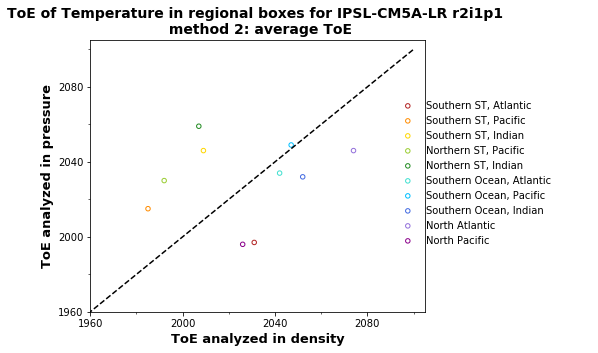

In [19]:
fig = plt.figure(figsize=(6,5))

l=['']*len(domain_names)

for idomain in range(len(domain_names)):
    col = domain_colors[idomain]
    l[idomain] = plt.scatter(dataToErho[idomain],dataToEz[idomain],color=col,s=20,facecolors='none', label=domain_names[idomain])
ax = plt.gca()
ax.set_title('ToE of '+legVar+' in regional boxes for '+model['name'] + ' r2i1p1 \n method 2: average ToE',fontsize=14,fontweight='bold')

    
ax.plot([1860,2000,2100],[1860,2000,2100], color='black', linestyle='--',zorder=1)

ax.set_ylim([1960,2105])
ax.set_xlim([1960,2105])
xmajorLocator = MultipleLocator(40)
xminorLocator = AutoMinorLocator(2)
ax.yaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_minor_locator(xminorLocator)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)

ax.set_xlabel('ToE analyzed in density', fontweight='bold',fontsize=13)
ax.set_ylabel('ToE analyzed in pressure', fontweight='bold',fontsize=13)

# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = fig.legend(l,domain_names,loc='center left',scatterpoints=1,frameon=False, bbox_to_anchor=(0.9, 0.5))

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Text at the bottom of the figure
#plt.figtext(.8,.01,'Computed by : compute_toe_z_inboxes.ipynb, '+date, fontsize=8, ha='center')

plotName = 'scatterplot_ToEzvsToEgamma_boxes_aveToE_'+v


plt.savefig('/home/ysilvy/figures/models/ToE_z_analysis/'+plotName+'.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')
